In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Read the dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
# mnist.train.next_batch(100)[0].reshape([100, 28, 28, 1])
print(mnist.train.next_batch(100)[0].shape)

(100, 784)


In [3]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        filter1 = tf.get_variable('d_f1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        bias1   = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        output1 = tf.nn.conv2d(input=images, filter=filter1, strides=[1, 1, 1, 1], padding='SAME')
        output1 = output1 + bias1
        output1 = tf.nn.relu(output1)
        output1 = tf.nn.avg_pool(output1, ksize=[1, 2, 2, 1], strides=[1,2,2,1], padding='SAME')
        
        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        filter2 = tf.get_variable('d_f2', [5,5,32,64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        bias2   = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        output2 = tf.nn.conv2d(input=output1, filter=filter2, strides=[1,1,1,1], padding='SAME')
        output2 = output2 + bias2
        output2 = tf.nn.relu(output2)
        output2 = tf.nn.avg_pool(output2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
        # First fully connected layer
        weight3 = tf.get_variable('d_w3', [7*7*64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        bias3   = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        output3 = tf.reshape(output2, [-1, 7*7*64])
        output3 = tf.matmul(output3, weight3) + bias3
        output3 = tf.nn.relu(output3)
        
        # Second fully connected layer
        weight4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        bias4   = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        output4 = tf.matmul(output3, weight4) + bias4
        
        # output4 contains unscaled values
        return output4

In [4]:
def generator(z, batch_size, z_dim):
    # From z_dim to 56*56 dimension
    weight1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    bias1   = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    output1 = tf.matmul(z, weight1) + bias1
    output1 = tf.reshape(output1, [-1, 56, 56, 1])
    output1 = tf.contrib.layers.batch_norm(output1, epsilon=1e-5, scope='bn1')
    output1 = tf.nn.relu(output1)
    
    # Generate 50 features
    weight2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    bias2   = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    output2 = tf.nn.conv2d(output1, weight2, strides=[1,2,2,1], padding='SAME')
    output2 = output2 + bias2
    output2 = tf.contrib.layers.batch_norm(output2, epsilon=1e-5, scope='bn2')
    output2 = tf.nn.relu(output2)
    output2 = tf.image.resize_images(output2, [56,56])

    # Generate 25 features
    weight3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    bias3   = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    output3 = tf.nn.conv2d(output2, weight3, strides=[1,2,2,1], padding='SAME')
    output3 = output3 + bias3
    output3 = tf.contrib.layers.batch_norm(output3, epsilon=1e-5, scope='bn3')
    output3 = tf.nn.relu(output3)
    output3 = tf.image.resize_images(output3, [56, 56])
    
    # Final convolution with one output channel
    weight4 = tf.get_variable('g_w4', [1,1,z_dim/4,1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    bias4   = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    output4 = tf.nn.conv2d(output3, weight4, strides=[1,2,2,1], padding='SAME')
    output4 = output4 + bias4
    output4 = tf.sigmoid(output4)
    
    # Dimension of output4: batch_size x 28 x 28 x 2
    return output4

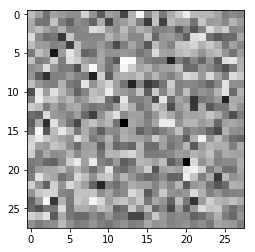

In [5]:
""" See the fake image we make """

# Define the plaaceholder and the graph
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

# For generator, one image for a batch
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

with tf.Session() as sess:    
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output, feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')
#     plt.savefig('/img/test_img.png')

In [6]:
tf.reset_default_graph()

In [7]:
batch_size = 1

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder')
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, [None, 28, 28, 1], name='x_placeholder')
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions)
# Gz holds the generated images

Dx = discriminator(x_placeholder)
# Dx will hold discriminator prediction probabilities for the real MNIST images

Dg = discriminator(Gz, reuse_variables=True)
# Dg will hold discriminator prediction probabilities for generated images

In [8]:
# Two Loss Functions for discirminator
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))

# Loss function for generator
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [9]:
# Get the variables for different network
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

# Train the discirminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [10]:
# """ For setting TensorBoard """

# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

In [11]:
""" Start Training Session """

saver = tf.train.Saver()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True


sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

dLossReal: 0.6944603 dLossFake: 0.69253296
dLossReal: 0.020741127 dLossFake: 2.4859723e-05
dLossReal: 4.8836314e-06 dLossFake: 2.4646937e-05


In [12]:
# Train generator and discriminator together
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})
    
    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

dLossReal: 3.47213e-05 dLossFake: 0.00040991275
dLossReal: 0.014160319 dLossFake: 1.628727e-11
dLossReal: 4.7505285e-08 dLossFake: 0.00090361305
dLossReal: 5.48509e-05 dLossFake: 2.6526943e-05
dLossReal: 8.095445e-10 dLossFake: 2.5115135e-14
dLossReal: 2.3158286e-11 dLossFake: 2.358053e-06
dLossReal: 2.4434481e-05 dLossFake: 6.765159e-10
dLossReal: 5.0304705e-10 dLossFake: 0.00010441404
dLossReal: 1.0805323e-07 dLossFake: 1.2938845e-05
dLossReal: 2.4006226e-06 dLossFake: 0.015963547
dLossReal: 9.8958044e-05 dLossFake: 0.0035066493
dLossReal: 0.001516403 dLossFake: 2.3949841e-08
dLossReal: 8.205239e-05 dLossFake: 2.0852838e-08
dLossReal: 0.0073237293 dLossFake: 7.790536e-07
dLossReal: 2.7895255e-06 dLossFake: 0.00014069566
dLossReal: 0.00015718507 dLossFake: 0.00017777568
dLossReal: 6.127018e-05 dLossFake: 0.0018819097
dLossReal: 2.5742676e-05 dLossFake: 0.00011334298
dLossReal: 2.8200351e-05 dLossFake: 0.0006580482
dLossReal: 5.1545827e-05 dLossFake: 0.00028340812
dLossReal: 1.0209005e

In [19]:
z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
_ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})
print(_)

None


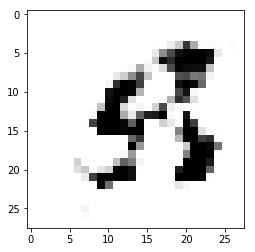

In [24]:
z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
generated_image = sess.run(Gz, feed_dict={z_placeholder: z_batch})
generated_image = generated_image.reshape([28, 28])
plt.imshow(generated_image, cmap='Greys')